# Using ICA to reduce artefacts

This section will show how to use an independent component analysis (ICA) approach to suppress ocular and cardiac artifacts. This will be done by first performing an ICA decomposition of the data after which the components reflecting the artifacts are identified manually. As a last step the artifact components are 'projected out'.

## Preparation

Important the relevant Python modules:

In [13]:
import os.path as op
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne_bids import BIDSPath, read_raw_bids
from mne.preprocessing import ICA

### File overview
The chapter relies on the input file (embedded in the BIDS structure):
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
~~~
and generates the output files
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif
~~~

Set the local paths to the data:

In [14]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '01'
meg_suffix = 'meg'
ann_suffix = 'ann'
ica_suffix = 'ica'
max_suffix = 'raw_sss'

#deriv_root = r'C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Preprocessing'
deriv_root = '/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing'

bids_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=max_suffix, 
            root=deriv_root, extension='.fif', check=False)

deriv_fname = bids_path.basename.replace(max_suffix, ica_suffix)
deriv_file_1 = op.join(bids_path.directory, deriv_fname)
deriv_file_2 = deriv_file_1.replace('run-01', 'run-02')
deriv_files = [deriv_file_1, deriv_file_2]  

print(bids_path)
print(deriv_file_1)

/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif
/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif


### Resampling and filtering of the raw data
In order to do the ICA decomposition efficiently and keep all sub-data sets in memory, we will first down-sample the data. We will use the datasets in which SSS was applied. We will then apply the resample function to downsample the data to 200 Hz and then apply a 1 - 40 Hz bandpass filter. The 1 Hz highpass is important for removing slow drifts which otherwise would make the ICA decomposition less efficient. After these operation the data sets are concatenated such that the ICA can be performed on the data sets in one hit.

In [15]:
for subfile in range(1, 3):
    raw = read_raw_bids(bids_path=bids_path, 
                     extra_params={'preload':True},
                     verbose=True)
    raw_resmpl = raw.copy().pick('meg')
    raw_resmpl.resample(200) # dowsample to 200 Hz
    raw_resmpl.filter(1, 40) # band-pass filtert from 1 to 40 Hz
    if subfile == 1:
        raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl])
        bids_path.update(run='02')
    else:
        raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl_all, raw_resmpl])
del raw_resmpl

Opening raw data file /Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif...
    Range : 208000 ... 1664999 =    208.000 ...  1664.999 secs
Ready.
Reading 0 ... 1456999  =      0.000 ...  1456.999 secs...


/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/3237970853.py:2: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/3237970853.py:2: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/3237970853.py:2: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s


Opening raw data file /Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif...


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.8s


    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...


/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/3237970853.py:2: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/3237970853.py:2: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/3237970853.py:2: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.8s


### Applying the ICA algorithm
Now we apply the ICA algorithm. We have chosen for the *fastica* approach as it is well established and widely used. However, other ICA methods are available in MNE-Python.

In [16]:
ica = ICA(method='fastica',
    random_state=97,
    n_components=30,
    verbose=True)

ica.fit(raw_resmpl_all,
    verbose=True)

Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 18.3s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,73 iterations on raw data (578200 samples)
ICA components,30
Available PCA components,306
Channel types,"mag, grad"
ICA components marked for exclusion,—


### Identifying the ICA components reflecting the artifacts
To plot the examples for the time-traces of the ICA components use:

In [17]:
%matplotlib inline
ica.plot_sources(raw_resmpl_all, title='ICA')

Creating RawArray with float64 data, n_channels=30, n_times=578200
    Range : 41600 ... 619799 =    208.000 ...  3098.995 secs
Ready.
Using qt as 2D backend.
Using pyopengl with version 3.1.6


To open the interactive version of the plot, run:

In [18]:
%matplotlib qt
ica.plot_sources(raw_resmpl_all, title='ICA')

Creating RawArray with float64 data, n_channels=30, n_times=578200
    Range : 41600 ... 619799 =    208.000 ...  3098.995 secs
Ready.
Using pyopengl with version 3.1.6


Use the left/right arrow-keys to scroll through the data and the up/down arrow-keys to scroll through the components. Right-click on the IC names to see the corrisponding topographies and other details.


When inspecting the traces, it is clear that ICA000 and ICA001 reflect eye-blinks as measured most strongly. Component ICA014 reflects saccades. Finally, ICA024 reflects the ECG.
This order of ICA components is specific to this data set and the seed (*random_state*) used for the ICA decomposition. For other data sets or using a different seed the components will come in a different order. Therefore the components associated with artifacts have to be identified manually.

**Question 1:** Estimate the frequency of the heart rate

**Question 2:** Identify the saccades in EOG014


To show the topographies of the each of the ICA components write:

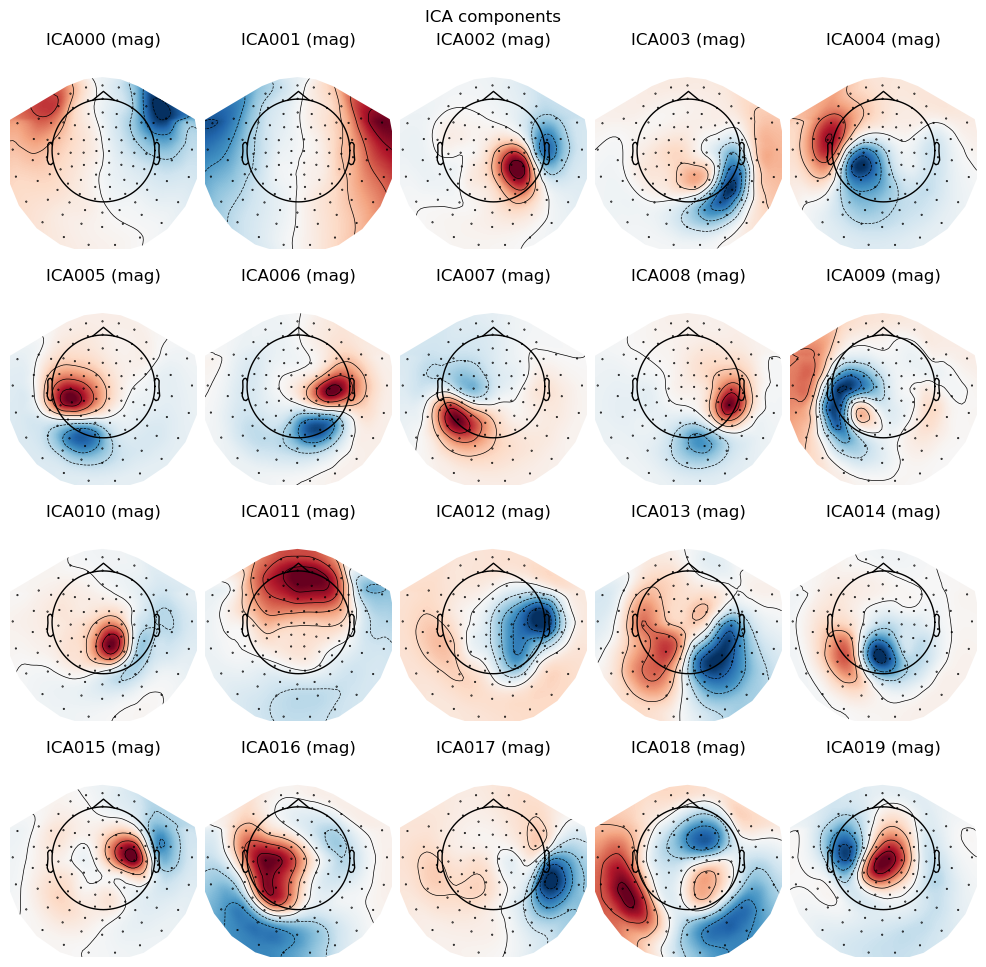

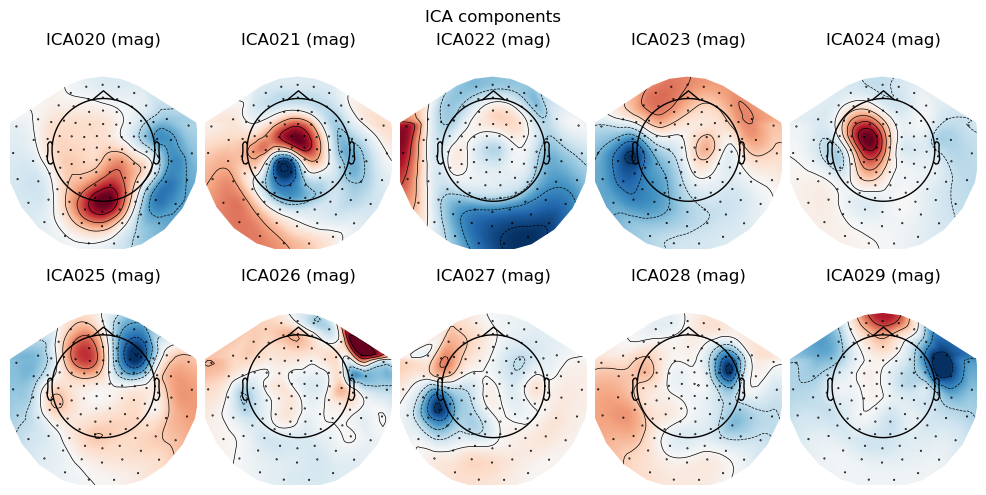

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 10 Axes>]

In [19]:
%matplotlib inline
ica.plot_components()

These plots show the topography associated with the magnetometers as they are more straightforward to interpret. The topography of ICA000 and ICA001 look like a classical eye-blink artifacts with strong activity over frontal left and right sensors of opposite polarity. The frontal negativity of ICA011 is associated with saccades. ICA022 looks like a typical ECG artifact as observed by the strong activity in the rim sensors stemming from the magnetic field circling the heart.

How many components should in general be removed? As a rule of thumb not more than a handful. Typically only remove components which clearly reflect a physiological artifact. Removing too many components might remove brain activity as well.

**Question 3:** Which component(s) might reflect the human alpha band activity? Base your argument both on the traces and topographies.


### Attenuating  the artifacts by applying the projections
Now that we have detected the ICA components associated with ocular and cardiac artifacts, we have to 'project out' them. This will be done by applying the ICA projections generated by *ica.exclude* to the original raw data which will be loaded again by looping over the sub-files. After the ICA projections have been applied (*ica.apply*) the data will be saved.

In [21]:
# Set the 4 components to exclude
ica.exclude = [0, 1, 11, 22]

# Loop over the subfiles
for subfile in range(1, 3):
    if subfile == 2:
        bids_path.update(run='02')

    raw_ica = read_raw_bids(bids_path=bids_path,
                     extra_params={'preload':True},
                     verbose=True)
    ica.apply(raw_ica)

    raw_ica.save(deriv_files[subfile-1], overwrite=True)

Opening raw data file /Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...
Applying ICA to Raw instance


/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/2093141450.py:9: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw_ica = read_raw_bids(bids_path=bids_path,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/2093141450.py:9: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw_ica = read_raw_bids(bids_path=bids_path,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/2093141450.py:9: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing

    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 306 PCA components
Overwriting existing file.
Writing /Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif


/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/2093141450.py:14: RuntimeWarning: This filename (/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ica.save(deriv_files[subfile-1], overwrite=True)


Closing /Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif
[done]
Opening raw data file /Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...
Applying ICA to Raw instance


/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/2093141450.py:9: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw_ica = read_raw_bids(bids_path=bids_path,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/2093141450.py:9: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw_ica = read_raw_bids(bids_path=bids_path,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/2093141450.py:9: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing

    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 306 PCA components
Overwriting existing file.
Writing /Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif


/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_29992/2093141450.py:14: RuntimeWarning: This filename (/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ica.save(deriv_files[subfile-1], overwrite=True)


Closing /Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif
[done]


## Plotting the data to check the artifact reduction

We will here examine some of the traces from one of the subfiles (#1) to demonstrate the artifact reduction.

Define a few frontal magnetometers to examine and include the EOG sensors:

In [22]:
chs = ['MEG0311', 'MEG0121', 'MEG1211', 'MEG1411']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]

Then plot the data prior to the ICA projections were applied. Use the arrow button to scroll through the trials.

In [23]:
%matplotlib inline
raw.plot(order=chan_idxs, duration=5)

Using pyopengl with version 3.1.6


Above shows the raw traces prior to the application of the ICA projections. Note the ocular artifacts in the MEG data at e.g. ~1 sec.

Then plot the same traces after the application of the ICA projections:

In [24]:
%matplotlib inline
raw_ica.plot(order=chan_idxs, duration=5)

Using pyopengl with version 3.1.6


As seen in the plot above, the ocular artifacts are clearly reduced.

## Preregistration and publication

Example text 
"The data were down sampled to 200Hz prior to Independent Component Analysis (ICA) and bandpass filtered at 1 – 40 Hz. Next the fastICA algorithm  (Hyvärinen and Oja, 2000) was applied to the segmented data as implemented in MNE Python. Clear components containing cardiac artefacts and eyeblinks (identified in time course and topographies of the ICA components) were removed in each subject (3 – 5 over subjects) in the raw unfiltered data. "



## References

* Hyvärinen A, Oja E. (2002) Independent component analysis: algorithms and applications. Neural Netw. 13(4-5):411-30. doi: 10.1016/s0893-6080(00)00026-5. 